In [1]:
import random
import pickle 
import datetime
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

INF = 10**9

def segment_intersection(p1, p2, p3, p4):
    
    def area(a, b, c):
        return (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])
    
    def intersection_check(a, b, c, d):
        if a > b:
            a, b = b, a
        if c > d:
            c, d = d, c
        return max(a, c) <= min(b, d)
    
    if not (intersection_check(p1[0], p2[0], p3[0], p4[0]) and intersection_check(p1[1], p2[1], p3[1], p4[1])):
        return False
    
    return area(p1, p2, p3) * area(p1, p2, p4) <= 0 and area(p3, p4, p1) * area(p3, p4, p2) <= 0
    
    
class Unit:
    def __init__(self, owner):
        self.owner = owner
        self.maxhp = self.curhp = 7
        self.maxeng = self.cureng = 2
    
    def getOwner(self):
        return self.owner
    
    def getCurHp(self):
        return self.curhp
    
    def getCurEng(self):
        return self.cureng
    
    def updEng(self, eng):
        self.cureng -= eng
    
    def damageFunction(self, dist):
        if dist <= 4:
            return 3
        if dist <= 6.5:
            return 2
        return 1
    
    def isAlive(self):
        return self.curhp > 0
    
    def newTurn(self):
        self.cureng = self.maxeng
    
    def getDamage(self, dist):
        self.curhp -= self.damageFunction(dist)
    

class Field:
    def __init__(self, de_map):
        self.width = len(de_map[0])
        self.height = len(de_map)
        self.field = [['0'] * self.width for _ in range(self.height)]
        for i in range(self.height):
            for j in range(self.width):
                self.field[i][j] = de_map[i][j]
    
    def __str__(self):
        res = ""
        for i in range(self.height):
            for j in range(self.width):
                if self.field[i][j] == '0':
                    res += '00 '
                elif self.field[i][j] == 'w':
                    res += 'ww '
                else:
                    res += str(self.field[i][j].getOwner()) + str(self.field[i][j].getCurHp()) + ' '
            res += '\n'
        return res
    
    def fromNumToCoords(self, n):
        return n // self.width, n % self.width
    
    def fromCoordsToNum(self, coords):
        return coords[0] * self.width + coords[1]
    
    def size(self):
        return self.width * self.height
    
    def isUnit(self, coords):
        x, y = coords
        if self.field[x][y] == '0' or self.field[x][y] == 'w':
            return False
        return True
    
    def addUnits(self, arr):
        for owner, x, y in arr:
            self.field[x][y] = Unit(owner)
    
    def addWalls(self, arr):
        for x, y in arr:
            self.field[x][y] = 'w'
    
    def delUnits(self, arr):
        for x, y in arr:
            self.field[x][y] = '0'
    
    def getAllWallsCoords(self):
        walls = []
        for i in range(self.height):
            for j in range(self.width):
                if self.field[i][j] == 'w':
                    walls.append((i, j))
        return walls
    
    def shootable(self, shoot_from, shoot_to):
        x1, y1 = shoot_from
        x2, y2 = shoot_to
        walls = self.getAllWallsCoords()
        for x, y in walls:
            if segment_intersection((x, y), (x + 1, y + 1), (x1 + 0.5, y1 + 0.5), (x2 + 0.5, y2 + 0.5)):
                return False
            if segment_intersection((x, y + 1), (x + 1, y), (x1 + 0.5, y1 + 0.5), (x2 + 0.5, y2 + 0.5)):
                return False
        return True
    
    def getShootableCoords(self, shoot_from):
        shootable = []
        for x in range(self.height):
            for y in range(self.width):
                if self.shootable(shoot_from, (x, y)):
                    shootable.append((x, y))
        return shootable
    
    def getDist(self, move_from, move_to):
        dist = [[INF] * self.width for _ in range(self.height)]
        x1, y1 = move_from
        x2, y2 = move_to
        if self.isUnit(move_to) or self.field[x2][y2] == 'w':
            return INF
        queue = [(x1, y1)]
        dist[x1][y1] = 0
        dx = [-1, 0, 1, 0]
        dy = [0, -1, 0, 1]
        while len(queue):
            x, y = queue.pop(0)
            for k in range(4):
                if 0 <= x + dx[k] < self.height and 0 <= y + dy[k] < self.width and self.field[x + dx[k]][y + dy[k]] != 'w' and not self.isUnit((x + dx[k], y + dy[k])):
                    if dist[x + dx[k]][y + dy[k]] == INF:
                        dist[x + dx[k]][y + dy[k]] = dist[x][y] + 1
                        queue.append((x + dx[k], y + dy[k]))
        return dist[x2][y2]
    
    def getPlayerUnits(self, owner):
        coords = []
        for i in range(self.height):
            for j in range(self.width):
                if self.isUnit((i, j)):
                    if self.field[i][j].getOwner() == owner:
                        coords.append((i, j))
        return coords
    
    def newTurn(self):
        for i in range(self.height):
            for j in range(self.width):
                if self.isUnit((i, j)):
                    if self.field[i][j].isAlive():
                        self.field[i][j].newTurn()
                    else:
                        self.field[i][j] = '0'
    
    def moveUnit(self, move_from, move_to):
        d = self.getDist(move_from, move_to)
        x, y = move_from
        x1, y1 = move_to
        if d > self.field[x][y].getCurEng() or d == -1:
            return False
        self.field[x][y].updEng(d)
        self.field[x1][y1], self.field[x][y] = self.field[x][y], '0'
    
    def attackUnit(self, attack_from, attack_to):
        x, y = attack_from
        x1, y1 = attack_to
        d = ((x - x1)**2 + (y - y1)**2)**(0.5)
        self.field[x1][y1].getDamage(d)
        if not self.field[x1][y1].isAlive():
            self.delUnits([(x1, y1)])
    
    def makeTurn(self, coords_from, coords_to):
        x1, y1 = coords_from
        x2, y2 = coords_to
        if self.isUnit(coords_to) and self.field[x1][y1].getOwner() != self.field[x2][y2].getOwner():
            if self.shootable(coords_from, coords_to):
                self.attackUnit(coords_from, coords_to)
        else:
            if self.getDist(coords_from, coords_to) <= self.field[x1][y1].getCurEng():
                self.moveUnit(coords_from, coords_to)
        
        
    def getState(self, owner):
        # if only 1 character per side
        x1, y1, x2, y2 = -1, -1, -1, -1
        for i in range(self.height):
            for j in range(self.width):
                if self.isUnit((i, j)):
                    if self.field[i][j].getOwner() == owner:
                        x1, y1 = i, j
                    else:
                        x2, y2 = i, j
        return [x1, y1, x2, y2]
                
    def getValidTurnsForUnit(self, coords):
        shoot = []
        move = []
        x, y = coords
        for i in range(self.width):
            for j in range(self.height):
                if self.field[x][y].getCurEng() > 0 and self.shootable(coords, (i, j)) and self.isUnit((i, j)) and self.field[i][j].getOwner() != self.field[x][y].getOwner():
                    shoot.append((i, j))
                if 0 < self.getDist(coords, (i, j)) <= self.field[x][y].getCurEng():
                    move.append((i, j))
        return move, shoot
    
    def isPlayerAlive(self, owner):
        return len(self.getPlayerUnits(owner)) > 0

In [2]:
map1 = [
'00000000000000',
'00000000000000',
'00wwww000www00',
'00w00000000w00',
'00w00ww0000w00',
'00w000000w0000',
'000000000w0000',
'0000w000000000',
'0000w000000w00',
'00w0000ww00w00',
'00w00000000w00',
'00www000wwww00',
'00000000000000',
'00000000000000'
]
map2 = [
'00000',
'00w00',
'00w00',
'00w00',
'00000'
]
map3 = [
'00000',
'00000',
'00w00',
'00000',
'00000'
]
map4 = [
'0000000',
'00www00',
'0000000',
'w00000w',
'0000000',
'00www00',
'0000000',
]

In [3]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
    
class RandomAgent:
    
    def __init__(self, owner):
        self.owner = owner
    
    def makeTurn(self, field):
        mine = field.getPlayerUnits(self.owner)
        random.shuffle(mine)
        for coords in mine:
            move, shoot = field.getValidTurnsForUnit(coords)
            if len(shoot) == 0 or 0.7 < random.random():
                if len(move) > 0:
                    new_coords = random.choice(move)
                    field.moveUnit(coords, new_coords)
            else:
                if len(shoot) > 0:
                    coords_shoot = random.choice(shoot)
                    field.attackUnit(coords, coords_shoot)
        return field


class DQLAgent:
    
    def __init__(self, owner, size):
        self.owner = owner
        self.network = nn.Sequential(
                                nn.Linear(4, 50),
                                nn.ReLU(),
                                nn.Linear(50, 50),
                                nn.ReLU(),
                                nn.Linear(50, 50),
                                nn.ReLU(),
                                nn.Linear(50, 50),
                                nn.ReLU(),
                                nn.Linear(50, size)
                                )
        self.opt = torch.optim.Adam(self.network.parameters(), lr=1e-4)
        self.n_actions = size
        self.state_dim = [4]
        
    def get_action(self, state, field, epsilon=0.):
        x, y = state[0], state[1]
        state = Variable(torch.FloatTensor(np.array(state)[None]))
        q_values = self.network(state).data.cpu().numpy()
        
        possible_actions = range(self.n_actions)

        if random.random() < epsilon:
            return random.choice(possible_actions)
        return max(possible_actions, key = lambda x : q_values[0][x])  
    
    def to_one_hot(self, y, n_dims=None):
        y_tensor = y.data if isinstance(y, Variable) else y
        y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
        n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
        y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
        return Variable(y_one_hot) if isinstance(y, Variable) else y_one_hot
    
    def where(self, cond, x_1, x_2):
        return (cond * x_1) + ((1-cond) * x_2)
    
    def compute_td_loss(self, states, actions, rewards, next_states, is_done, gamma = 0.99, check_shapes = False):
        states = Variable(torch.FloatTensor(states))
        actions = Variable(torch.IntTensor(actions))
        rewards = Variable(torch.FloatTensor(rewards))
        next_states = Variable(torch.FloatTensor(next_states))
        is_done = Variable(torch.FloatTensor(is_done))

        predicted_qvalues = self.network(states)

        predicted_qvalues_for_actions = torch.sum(predicted_qvalues * self.to_one_hot(actions, self.n_actions), dim=1)

        predicted_next_qvalues = self.network(next_states)

        next_state_values = torch.max(predicted_next_qvalues, dim = 1)[0]

        target_qvalues_for_actions = rewards + gamma * next_state_values

        target_qvalues_for_actions = self.where(is_done, rewards, target_qvalues_for_actions)

        loss = F.mse_loss(predicted_qvalues_for_actions, target_qvalues_for_actions.detach())

        return loss

In [15]:
field = Field(map4)
field.addUnits([(1, 6, 3), (2, 0, 3)])

print(field)

00 00 00 27 00 00 00 
00 00 ww ww ww 00 00 
00 00 00 00 00 00 00 
ww 00 00 00 00 00 ww 
00 00 00 00 00 00 00 
00 00 ww ww ww 00 00 
00 00 00 17 00 00 00 



In [16]:
def generate_session(A, B, t_max = 100, epsilon = 0., train = False):
    total_reward = 0
    field = Field(map4)
    field.addUnits([(1, 6, 3), (2, 0, 3)])

    to_learn = []
    
    for t in range(t_max):
        s = field.getState(1)
        a = field.fromNumToCoords(A.get_action(s, field, epsilon = epsilon))
        field.makeTurn((s[0], s[1]), a)
        next_s = field.getState(1)
        done, r = False, 0
        field = B.makeTurn(field)
        done = ((not field.isPlayerAlive(1)) or (not field.isPlayerAlive(2)))
        r = 0
        if done and field.isPlayerAlive(1):
            r = 1
        
        if train:
            #to_learn.append(([s], [field.fromCoordsToNum(a)], [next_s], [done]))
            A.opt.zero_grad()
            A.compute_td_loss([s], [field.fromCoordsToNum(a)], [r], [next_s], [done]).backward()
            A.opt.step()
        
        total_reward += r
        field.newTurn()
        if done:
            break
    r = 0
    if field.isPlayerAlive(1) and not field.isPlayerAlive(2):
        r = 1
    if train:
        for s, a, next_s, done in to_learn:
            A.opt.zero_grad()
            A.compute_td_loss(s, a, [r], next_s, done).backward()
            A.opt.step()
    return total_reward


In [20]:
A = DQLAgent(1, 25) # field.size()
B = RandomAgent(2)

epsilon = 0.2

for_plot = []

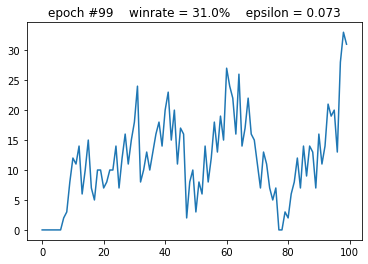

In [21]:
from IPython.display import clear_output

for i in range(100):
    session_cnt = 100
    session_rewards = [generate_session(A, B, epsilon = epsilon, train = True) for _ in range(session_cnt)]
    #session_rewards = [generate_session(A, B) for _ in range(session_cnt)]
    #print("epoch #{}\twinrate = {:.1f}%\tepsilon = {:.3f}".format(i, np.mean(session_rewards) * 100, epsilon))
    
    epsilon *= 0.99 #reduce exploration coef over time
    if epsilon < 0.02:
        if np.mean(session_rewards) > 0.5:
            epsilon = 0.05
        else:
            epsilon = 0.1
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
    
    for_plot.append(np.mean(session_rewards) * 100)
    clear_output(True)
    plt.title("epoch #{}    winrate = {:}%    epsilon = {:.3f}".format(i, np.mean(session_rewards) * 100, epsilon))
    plt.plot(for_plot)
    plt.show()
    
    if np.mean(for_plot[-1]) > 50:
        print ("You Win!")
        break

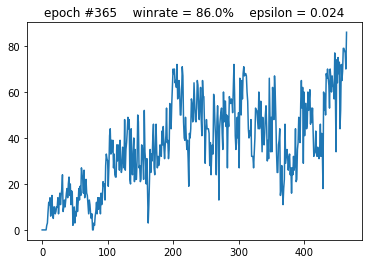

You Win!


In [22]:
for i in range(400):
    session_cnt = 100
    session_rewards = [generate_session(A, B, epsilon = epsilon, train = True) for _ in range(session_cnt)]
    #session_rewards = [generate_session(A, B) for _ in range(session_cnt)]
    #print("epoch #{}\twinrate = {:.1f}%\tepsilon = {:.3f}".format(i, np.mean(session_rewards) * 100, epsilon))
    
    epsilon *= 0.99 #reduce exploration coef over time
    if epsilon < 0.02:
        if np.mean(session_rewards) > 0.5:
            epsilon = 0.05
        else:
            epsilon = 0.1
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
    
    for_plot.append(np.mean(session_rewards) * 100)
    clear_output(True)
    plt.title("epoch #{}    winrate = {:}%    epsilon = {:.3f}".format(i, np.mean(session_rewards) * 100, epsilon))
    plt.plot(for_plot)
    plt.show()
    
    if np.mean(for_plot[-1]) > 80:
        print ("You Win!")
        break

In [23]:
import pickle 
import datetime

now = str(datetime.datetime.now())[5:-7]
now = now.replace(':', "_")
print(now)

with open('map4.pickle', 'wb') as f:
    pickle.dump(A, f)

#with open('m2g1.pickle', 'rb') as f:
#    A = pickle.load(f)

05-22 09_29_05


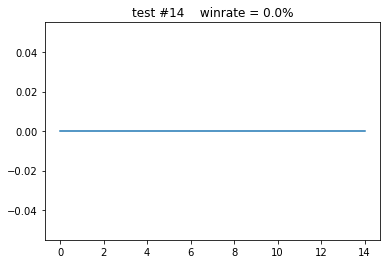

In [17]:
from IPython.display import clear_output

def test(A):
    B = RandomAgent(2)
    for_plot = []
    for i in range(15):
        session_cnt = 50
        session_rewards = [generate_session(A, B) for _ in range(session_cnt)]
        #print("epoch #{}\twinrate = {:.1f}%\tepsilon = {:.3f}".format(i, np.mean(session_rewards) * 100, epsilon))

        for_plot.append(np.mean(session_rewards) * 100)
        clear_output(True)
        plt.title("test #{}    winrate = {:}%".format(i, np.mean(session_rewards) * 100))
        plt.plot(for_plot)
        plt.show()

with open('map4.pickle', 'rb') as f:
    testA = pickle.load(f)

test(testA)

In [ ]:
with open('map2.pickle', 'rb') as f:
    A = pickle.load(f)

